## 正则化线性回归
一个水库的流出水量以及水库水位进行正则化线性归回。然后将会探讨方差-偏差的问题
### 数据可视化


In [4]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = sio.loadmat('../data/andrew_ml_ex55139/ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

###  正则化线性回归代价函数
$J\left( \theta \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{[({{({h_\theta}({{x}^{(i)}})-{{y}^{(i)}})}^{2}}+\lambda \sum\limits_{j=1}^{n}{\theta _{j}^{2}})]}$

In [6]:
#为输入值添加偏置X0
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
print(X.shape,Xval.shape,Xtest.shape)

(12, 2) (21, 2) (21, 2)


In [7]:
def cost(theta,X,y):
    theta = np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    m=X.shape[0]
    inner = np.power((X*theta.T - y.T),2)
    return np.sum(inner)/(2*m)

In [8]:
def costReg(theta,X,y,reg=1):
    m=X.shape[0]
    return  cost(theta,X,y)+ np.sum(np.power(theta[1:],2))/(2*m)

In [9]:
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1),cost(theta, X, y)

(303.9931922202643, 303.9515255535976)

In [31]:
# 正则化线性回归的梯度

3639.9193115709686

In [10]:
def gradient(theta,X,y):
    theta = np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    m=X.shape[0]
    dis = (X * theta.T) - y.T
    term= dis.T * X
    return term/m

In [21]:
def gradientReg(theta, X, y, reg = 1):
    m=X.shape[0]
    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta
    regularized_term = (reg/m)*regularized_term
    return gradient(theta,X,y) + regularized_term

In [22]:
gradientReg(theta, X, y, 1),gradient(theta,X,y)

(matrix([[-15.30301567, 598.25074417]]),
 matrix([[-15.30301567, 598.16741084]]))

### 拟合线性回归

In [23]:
# 调用工具库找到theta最优解
theta = np.ones(X.shape[1])
final_theta = opt.minimize(fun=costReg, x0=theta, args=(X, y, 0), method='TNC', jac=gradientReg, options={'disp': True}).x
final_theta

array([13.08790362,  0.36777923])

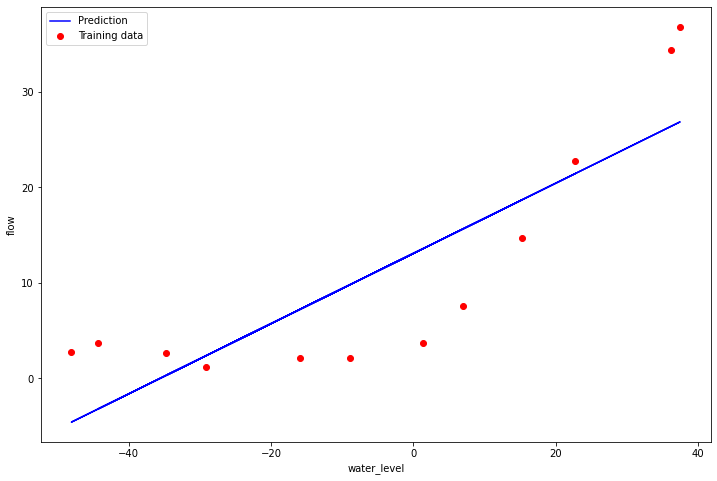

In [24]:
# 作图拟合
predict  = X*(np.matrix(final_theta).T)
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X[:,1], y, c='r', label="Training data")
plt.plot(X[:, 1], predict, c='b', label="Prediction")
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

### 方差和偏差

机器学习中的一个重要概念是偏差-方差权衡。偏差较大的模型会欠拟合，而方差较大的模型会过拟合

#### 学习曲线
1. 使用训练集的子集来拟合应模型
2. 在计算训练代价和验证集代价时，没有用正则化 
3. 记住使用相同的训练集子集来计算训练代价 

$J_{train}(\theta) = \frac{1}{m}\sum_\limits{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2$

In [25]:
def linear_regression(X,y,l=1):
    """linear regression
        args:
            X: feature matrix, (m, n+1) # with incercept x0=1
            y: target vector, (m, )
            l: lambda constant for regularization
        return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])
    res=opt.minimize(fun=costReg, 
                        x0=theta, 
                        args=(X, y, l), 
                        method='TNC', 
                        jac=gradientReg,
                        options={'disp': True})
    return res

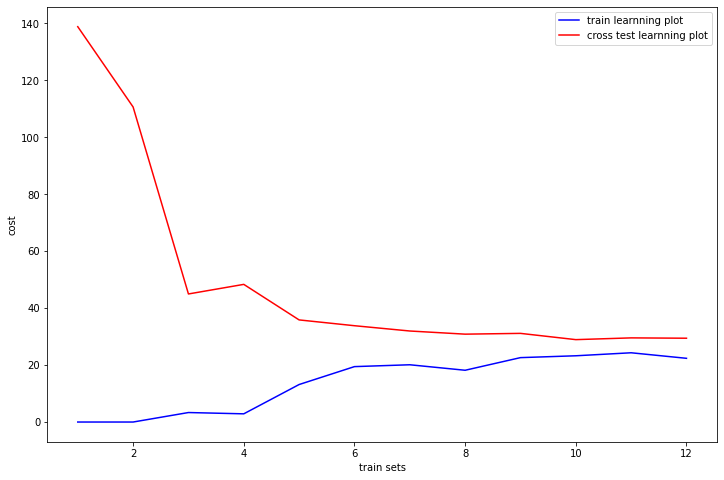

In [26]:
#初始化学习曲线tc 和cv得cost值
training_cost, cv_cost = [], []
m=X.shape[0]
for i in range(m):
    res = linear_regression(X[:i+1,:],y[:i+1])
    training_cost.append(costReg(res.x, X[:i+1, :], y[:i+1], 0)) 
    cv_cost.append(costReg(res.x,Xval,yval,0))
# 作图展示训练得学习曲线和交叉验证得曲线对比
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(1,m+1), training_cost, c='b', label="train learnning plot")
plt.plot(np.arange(1,m+1), cv_cost, c='r', label="cross test learnning plot")
ax.set_xlabel('train sets')
ax.set_ylabel('cost')
ax.legend()
plt.show()

可以看出来上面的图像，表现的高偏差，说明我们给定的特征值不足，导致欠拟合。使用更高阶得多项式来拟合

In [27]:
# 定义哥函数返回训练特征值得1-n次幂
def features(x,power,as_ndarray=False):
    data={'f{}'.format(i) : np.power(x,i) for i in range(1,power+1)}
    df = pd.DataFrame(data)
    return df.values if as_ndarray else df

In [28]:
X1 = features(X[:,1:].ravel(),power=3) # 分别表示x x^2 x^3 
X1
# X[:,1:].ravel()

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


### 多项式回归
    使用之前的代价函数和梯度函数
    扩展特征到8阶特征
    使用 归一化 来处理X^n
    λ=0


In [29]:
# 特征值归一化 ，统一量级会让梯度下降收敛的更快，做法就是，将每类特征减去他的平均值后除以标准差
def normalize_feature(df):
    return df.apply(lambda column: (column -  column.mean())/column.std())

In [30]:
# 使用之前数据（未进行插入处理前）
def prepare_poly_data(*args,power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        df = features(x, power=power)
        ndarr=normalize_feature(df).values
        return np.insert(ndarr,0,np.ones(ndarr.shape[0]),axis=1)
    return [prepare(x)  for x in args]

In [16]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X[:,1:].ravel(), Xval[:,1:].ravel(), Xtest[:,1:].ravel(), power=8)
X_poly[:1,:]

array([[ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
         0.30661792, -0.59087767,  0.3445158 , -0.50848117]])

In [32]:
# 同理做出学习曲线图
def llearning_curve(X, Xinit, y, Xval, yval, l=0):
    training_cost,cov_cost=[],[]
    m = X.shape[0]
    for i in range(1,m+1):
        res  =linear_regression(X[:i,:],y[:i],l)
        training_cost.append(costReg(res.x,X[:i,:],y[:i],l))
        cov_cost.append(costReg(res.x,Xval,yval,l))
    fig, ax = plt.subplots(2,  1, figsize=(12, 12))
    ax[0].plot(np.arange(1,m+1), training_cost, c='b', label="train learnning plot")
    ax[0].plot(np.arange(1,m+1), cv_cost, c='r', label="cross test learnning plot")
    ax[0].set_xlabel('train sets')
    ax[0].set_ylabel('cost')
    ax[0].legend()
    # 预测结果
    xparinit = np.linspace(-50,50,100)
    fitxtmp = prepare_poly_data(xparinit,power=8)[0]
    predict  = fitxtmp*np.matrix(linear_regression(X,y,l).x).T
    ax[1].plot(xparinit, predict, c='b', label="Prediction")
    ax[1].scatter(Xinit, y, c='r', label="Training data")
    ax[1].set_xlabel('init set')
    ax[1].set_ylabel('perdict plot')
    ax[1].legend()

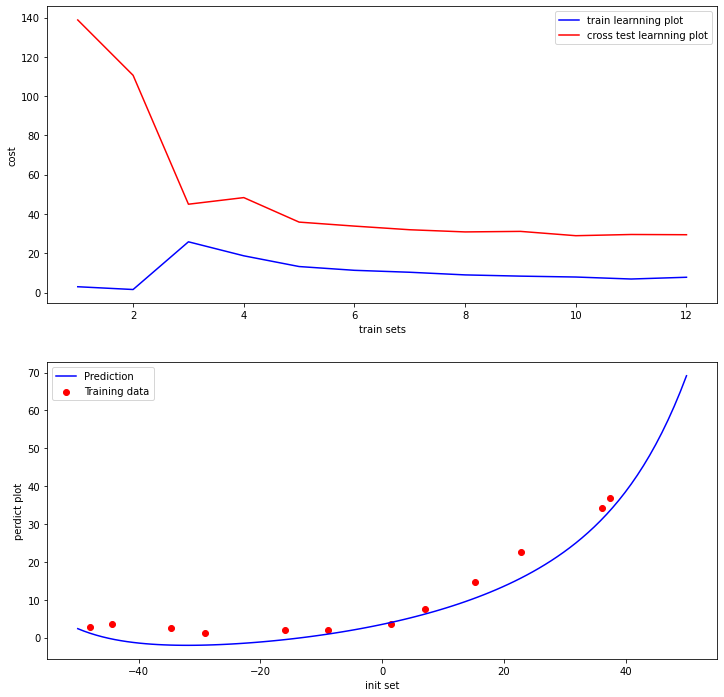

In [33]:
llearning_curve(X_poly, X[:,1:].ravel(), y, Xval_poly, yval, l=0)

可以看的上图training和cross test得cost值中间有比较大得间距，并且training cost为0，可知我们选取特征值过多导致过拟合

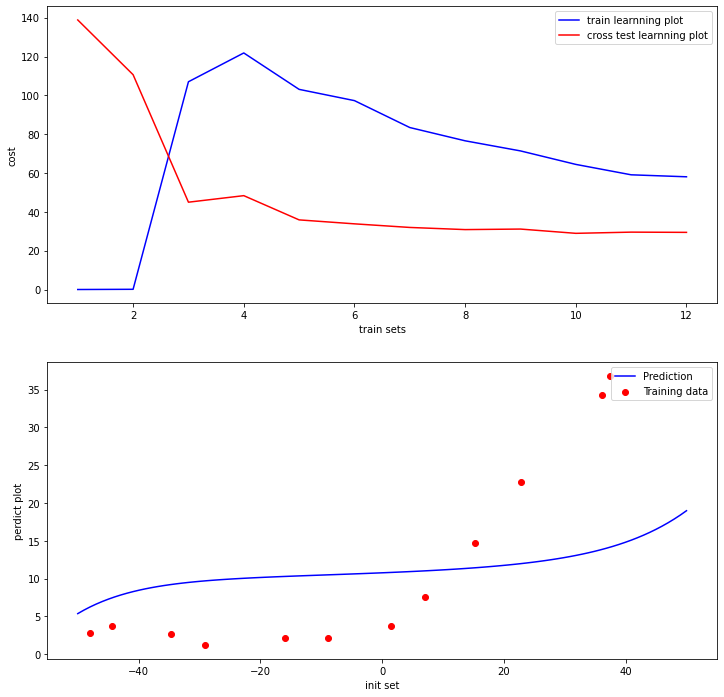

In [34]:
llearning_curve(X_poly, X[:,1:].ravel(), y, Xval_poly, yval, l=100)

上面λ过大导致惩罚过大导致欠拟合，下面我们通过学习曲线找到合适得lambda


In [37]:
l_candidate = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
training_cost, cv_cost = [], []
for l in l_candidate:
    res = linear_regression(X_poly, y, l)
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    training_cost.append(tc)
    cv_cost.append(cv)

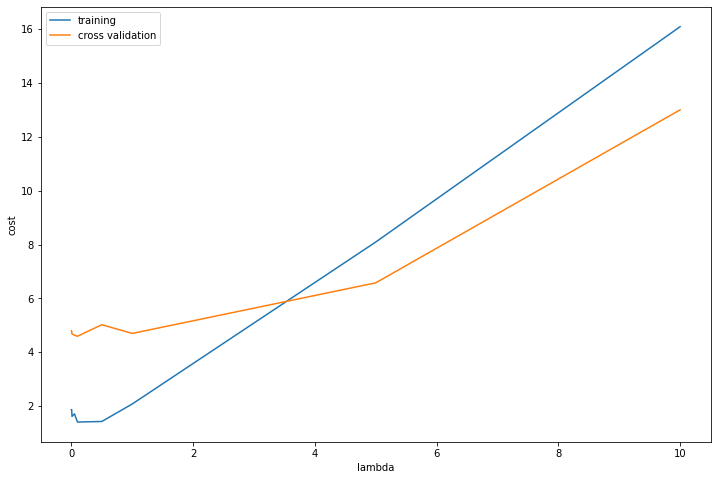

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(l_candidate, training_cost, label='training')
ax.plot(l_candidate, cv_cost, label='cross validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

由上图可以看的λ大致为0.05时，交叉验证和训练得cost值都达到最小

In [77]:
# 用测试集合和我们预测集合比较，这里我们去λ=0.1带入

# 预测值与实际值比较
# from sklearn.metrics import classification_report#这个包是评价报告
# l=0.1
# predict = Xtest_poly*np.matrix(linear_regression(X_poly, y, l).x).T
# predict = np.ravel(predict)
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 6.102805525119665
test cost(l=0.001) = 6.099405302552596
test cost(l=0.005) = 6.088825756186704
test cost(l=0.01) = 6.114005866347766
test cost(l=0.05) = 6.039040607353176
test cost(l=0.1) = 6.400300122399856
test cost(l=0.5) = 7.379791625869414
test cost(l=1) = 7.466316277342421
test cost(l=5) = 16.484249914815152
test cost(l=10) = 27.71507115138034
